In [136]:
import numpy as np
import pandas as pd
import emcee
import corner
import time
import scipy.optimize as op
from allsn_info import get_at2019dge
from helper.arnett import model_arnett_Ltph
from multiprocessing import Pool
from helper import phys
from helper.mcmcfit import mylinear_fit
from helper.models import model_piro15_bol

import matplotlib
import matplotlib.pyplot as plt
fs = 14
matplotlib.rcParams['font.size']=fs

## Method1: Model Fitting

In [34]:
filename = "./helper/piromodel/2.0/sampler.h5"
reader = emcee.backends.HDFBackend(filename)
samples = reader.get_chain(discard=1000, flat=True)
lgR_sigmas = np.percentile(samples[:,0], (0.13, 2.27, 15.87, 50, 84.13, 97.73, 99.87))
lgM_sigmas = np.percentile(samples[:,1], (0.13, 2.27, 15.87, 50, 84.13, 97.73, 99.87))
t0_sigmas = np.percentile(samples[:,2], (0.13, 2.27, 15.87, 50, 84.13, 97.73, 99.87))
E51_sigmas = np.percentile(samples[:,3], (0.13, 2.27, 15.87, 50, 84.13, 97.73, 99.87))
Mcore_sigmas = np.percentile(samples[:,4], (0.13, 2.27, 15.87, 50, 84.13, 97.73, 99.87))

Renv = 10**lgR_sigmas[3] 
Menv = 10**lgM_sigmas[3] 
t0 =t0_sigmas[3]
Mcore = Mcore_sigmas[3]
E51 = E51_sigmas[3]

In [67]:
data = pd.read_csv('../data/otherSN/Yao2020/bbdata.csv')
t_data = data['t'].values - 3.3 - t0
L_data = data['Lbb'].values
L_unc_data = data['Lbb_unc'].values
lgL_data = data['lgLbb'].values
lgL_unc_data = data['lgLbb_unc'].values

In [69]:
tgrid = np.linspace(0, 30, 100)
Lp15 = model_piro15_bol(tgrid, Renv, Menv, E51, Mcore)
lgLp15 = np.log10(Lp15)

In [70]:
result = get_at2019dge()
tb0 = result['tb']

In [73]:
tb0 = tb0[tb0['filter'].values=='r']
tb0 = tb0[tb0.instrument!="P60+SEDM"]
tb0 = tb0[(tb0.tmax_of-t0) > max(t_data[~ind_rough])]
t_quasi = tb0["tmax_of"].values -t0
Lquasi = tb0["Llambda"].values * tb0['wave'].values
Lquasi_unc = tb0["Llambda_unc"].values * tb0['wave'].values
lgLquasi = np.log10(Lquasi)
lgLquasi_unc = Lquasi_unc / Lquasi / np.log(10)

In [75]:
Lp15_data = model_piro15_bol(t_data, Renv, Menv, E51, Mcore)

In [80]:
L_data_resi = L_data - Lp15_data
lgL_data_resi = np.log10(L_data_resi)

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in log10
  


<IPython.core.display.Javascript object>


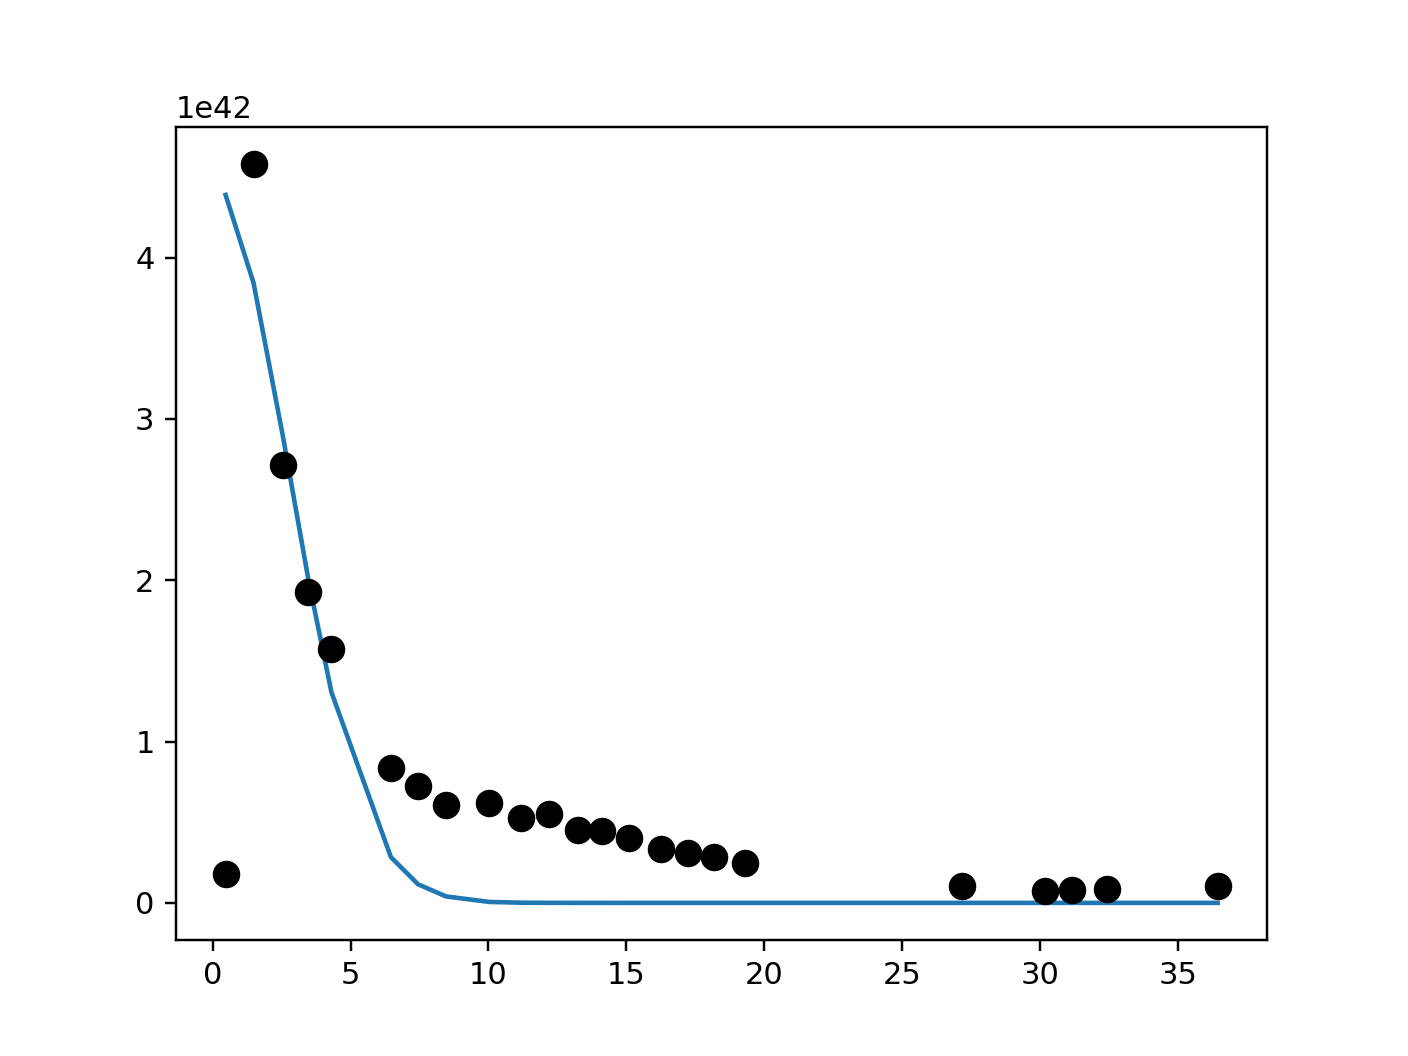

In [79]:
plt.figure()
plt.plot(t_data, Lp15_data)
plt.plot(t_data, L_data, 'ko')

In [81]:
lgL_data_resi

array([        nan, 41.86832449,         nan,         nan, 41.42458297,
       41.74061532, 41.78542986, 41.7547515 , 41.78554312, 41.72205708,
       41.73861407, 41.65627031, 41.65054164, 41.60566619, 41.52335881,
       41.48843609, 41.45037863, 41.38877873, 41.00947481, 40.86128577,
       40.89510818, 40.92654677, 41.01173316])

<IPython.core.display.Javascript object>


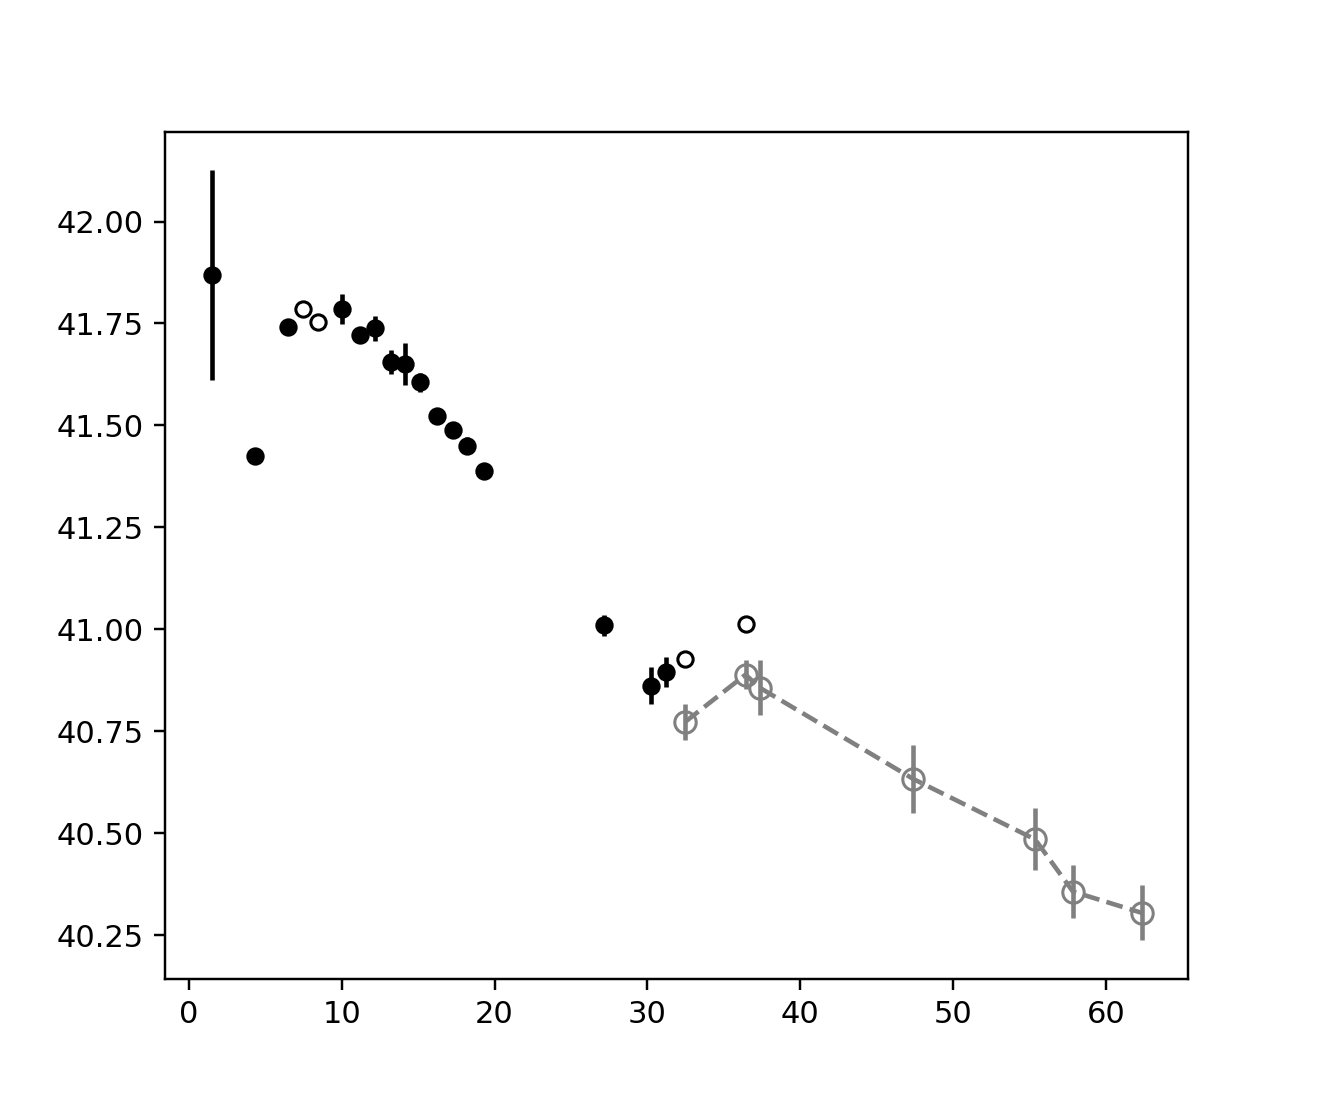

In [83]:
plt.figure(figsize=(6, 5))
ax = plt.subplot(111)
ax.errorbar(t_quasi, lgLquasi, lgLquasi_unc, fmt='--o', color = "grey", markerfacecolor='none', zorder = 3, markersize=7)

ax.errorbar(t_data[~ind_rough], lgL_data_resi[~ind_rough], lgL_unc_data[~ind_rough], fmt='ok', zorder = 3, markersize=5)
ax.plot(t_data[ind_rough], lgL_data_resi[ind_rough], 'ok', mfc='white', zorder = 3, markersize=5)
#ax.plot(t_data, lgL_data, ':k', zorder = 1)


In [106]:
x1 = t_data[~ind_rough]
y1 = lgL_data_resi[~ind_rough]
ey1 = lgL_unc_data[~ind_rough]
ix1 = (~np.isnan(y1))&(x1 > 3)
x1 = x1[ix1]
y1 = y1[ix1]
ey1 = ey1[ix1]

In [111]:
x2 = t_data[ind_rough]
y2 = lgL_data_resi[ind_rough]
ey2 = lgL_unc_data[ind_rough]
ix2 = (~np.isnan(y2))&(x2<20)
x2 = x2[ix2]
y2 = y2[ix2]
ey2 = ey2[ix2]
ey2 = np.ones(len(ey2))*0.05

In [112]:
x3 = t_quasi
y3 = lgLquasi
ey3 = lgLquasi_unc

In [117]:
x = np.hstack([x1, x2, x3])
y = np.hstack([y1, y2, y3])
ey = np.hstack([ey1, ey2, ey3])
ix = np.argsort(x)
x = x[ix]
y = y[ix]
ey = ey[ix]

In [160]:
10**max(y)

6.1029964381467326e+41

<IPython.core.display.Javascript object>


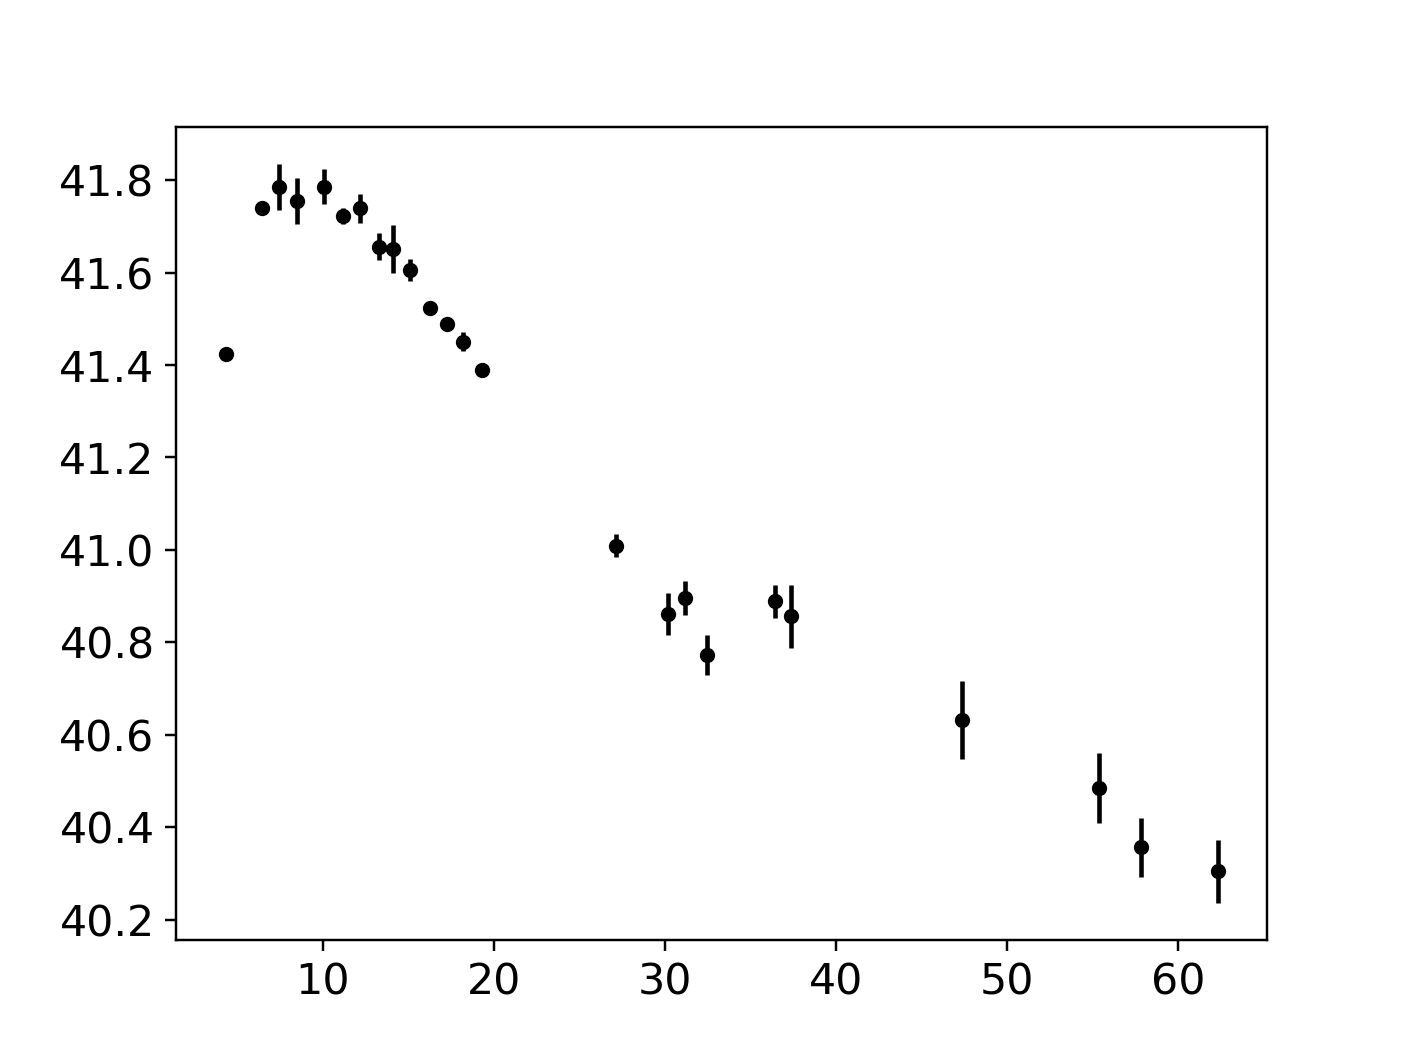

<ErrorbarContainer object of 3 artists>

In [158]:
plt.figure()
plt.errorbar(x, y, ey, fmt= ".k")

In [122]:
xyey = np.vstack([x, y, ey])
np.savetxt("./helper/Lbb_p15subtracted.txt", xyey)

### Photospheric phase Arnett model -- modified

In [123]:
from helper.arnett import main_arnettrun

In [125]:
# main_arnettrun()
# This takes some time to run

In [126]:
filename = "./helper/arnettmodel/sampler.h5"
reader = emcee.backends.HDFBackend(filename)

In [127]:
samples = reader.get_chain(discard=200, flat=True)
lgprobs = reader.get_log_prob(discard=200, flat=True)
print (samples.shape)
print (lgprobs.shape)

(420000, 3)
(420000,)


In [129]:
taum_sigmas = np.percentile(samples[:,0], (0.13, 2.27, 15.87, 50, 84.13, 97.73, 99.87))
lgMni_sigmas = np.percentile(samples[:,1], (0.13, 2.27, 15.87, 50, 84.13, 97.73, 99.87))
t0_sigmas = np.percentile(samples[:,2], (0.13, 2.27, 15.87, 50, 84.13, 97.73, 99.87))

In [130]:
paramsNames= [r"$\tau_{\rm m}$", 
                 'lg' +r'$M_{\rm Ni}$', 
                 r"$t_0$"]
quantiles=[0.1587, 0.5, 0.8413]

In [135]:
corner.corner?

<IPython.core.display.Javascript object>


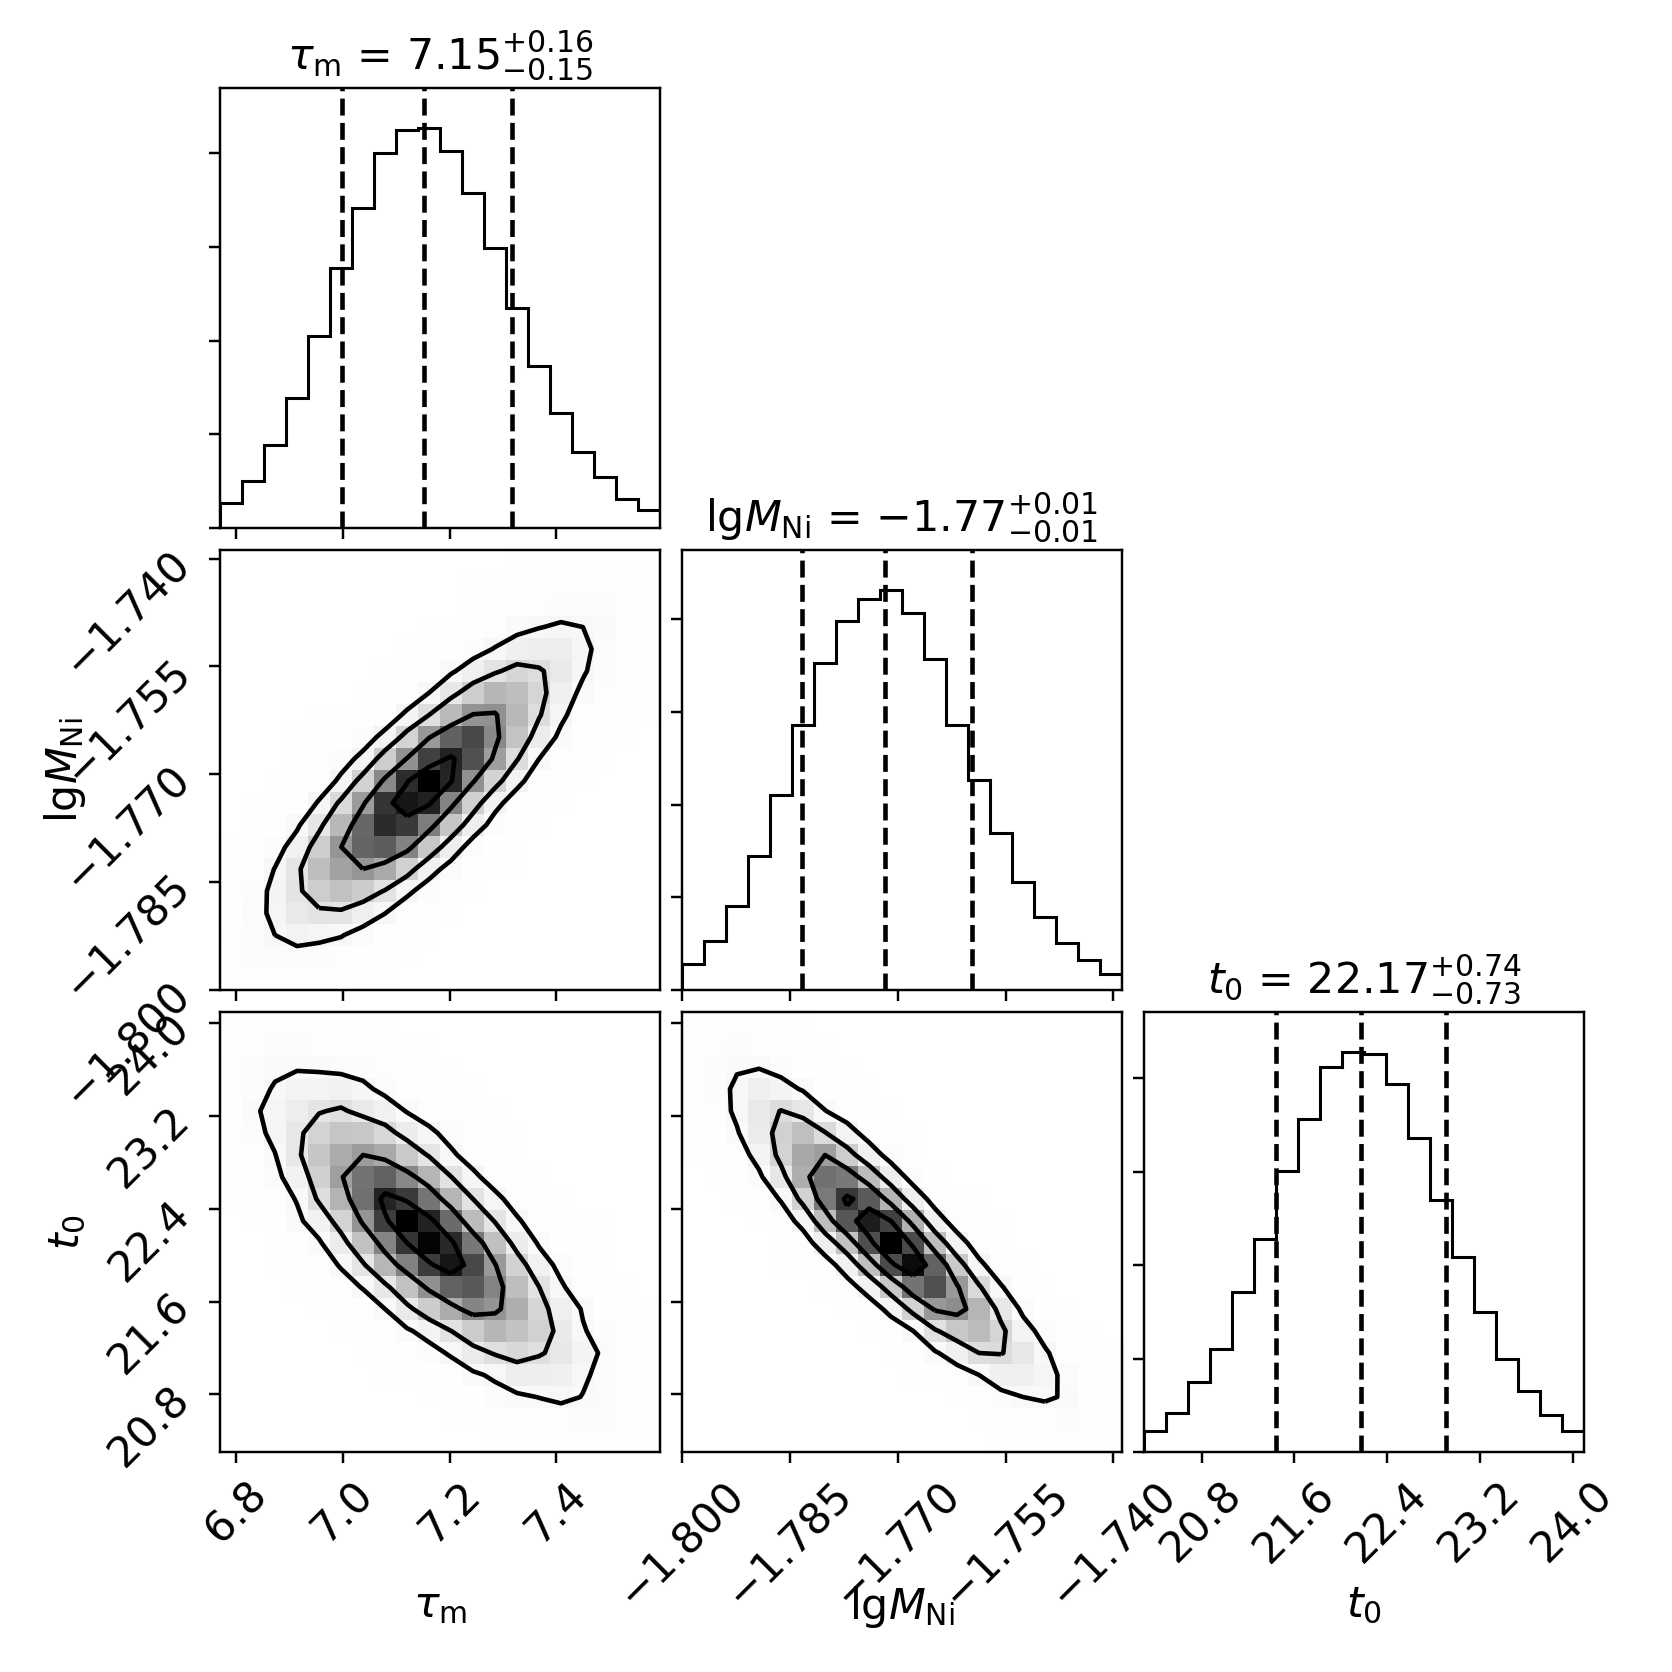

In [185]:
corner.corner(samples, labels = paramsNames, quantiles = quantiles, 
              range = [0.99, 0.99, 0.99],
              show_titles=True, plot_datapoints=False, 
               title_kwargs = {"fontsize": fs})
plt.savefig("../paper/figures/corner_arnett_modified.pdf")

In [151]:
taum_ = taum_sigmas[3]
taum_unc_right = taum_sigmas[4]-taum_sigmas[3]
taum_unc_left = taum_sigmas[3]-taum_sigmas[2]
print ("tau_m = %.2f + %.2f - %.2f day"%(taum_, taum_unc_right, taum_unc_left))

tau_m = 7.15 + 0.16 - 0.16 day


In [161]:
Mni = 10**lgMni_sigmas[3] 
Mni_unc_left = 10**lgMni_sigmas[3] - 10**lgMni_sigmas[2] 
Mni_unc_right = 10**lgMni_sigmas[4] - 10**lgMni_sigmas[3] 
print ("%.2f (+%.2f) (-%.2f) 1e-2 Msun"%(Mni*100, Mni_unc_right*100, Mni_unc_left*100))

1.69 (+0.05) (-0.04) 1e-2 Msun


In [162]:
t0_ = t0_sigmas[3]
t0_unc_right = t0_sigmas[4]-t0_sigmas[3]
t0_unc_left = t0_sigmas[3]-t0_sigmas[2]
print ("tau_m = %.2f + %.2f - %.2f day"%(t0_, t0_unc_right, t0_unc_left))

tau_m = 22.17 + 0.74 - 0.73 day


Estimate ejecta mass

In [154]:
kappa_opt = 0.07 # relevant for stripped envelope supernova
v_ej = 8150 * 1e+5
Mej_ = (taum_ * 24 * 3600)**2 * 13.8 * phys.c / 2 / kappa_opt * v_ej / phys.sm
Mej_unc_right = ((taum_+taum_unc_right) * 24 * 3600)**2 * 13.8 * phys.c / 2 / kappa_opt * v_ej / phys.sm - Mej_
Mej_unc_left = Mej_ - ((taum_-taum_unc_left) * 24 * 3600)**2 * 13.8 * phys.c / 2 / kappa_opt * v_ej / phys.sm 

In [156]:
Mej_

0.4625421141641987

In [153]:
Mej_unc_right

0.021525976976799754

In [157]:
Mej_unc_left

0.019888387087278747

## Method2: KK19 Equations
An improvement from the Arnett relations.

In [163]:
Lpeak = 6 * 10**(41)
tpeak = 9 * 86400
ts = 8.8*86400
beta = 4/3
L0 = Lpeak * beta**2 * tpeak**2 / 2 / ts**2 / (1 - (1 + beta*tpeak/ts)*np.exp(-beta * tpeak / ts))
epsilon_Ni = 3.9e+10 # erg / g / s
M_Ni = L0 / (epsilon_Ni) / phys.sm

In [164]:
M_Ni

0.018185824470821354

\begin{align}
x &= \frac{t_{\rm peak}}{t_{\rm d}}\\
x &= 0.11 {\rm ln} (1 + 9 \frac{8.8}{9}x) + 0.36
\end{align}

In [169]:
x = np.linspace(0.1, 1, 100)

In [170]:
y = 0.11 * np.log(1 + 8.8*x) + 0.36

<IPython.core.display.Javascript object>


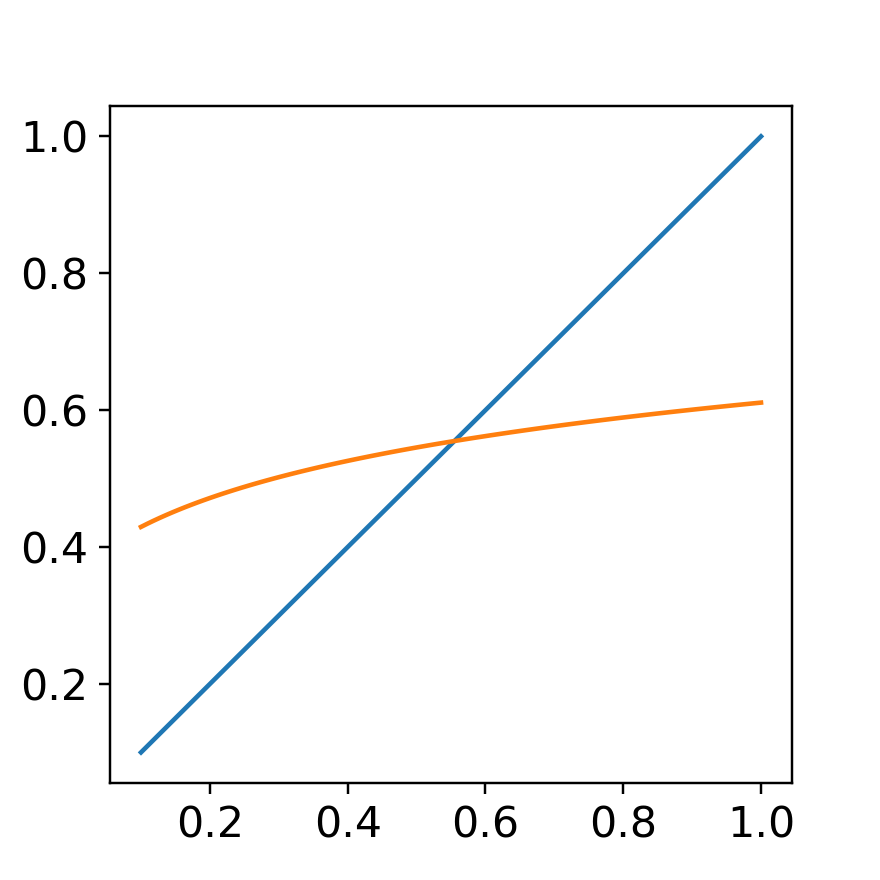

In [176]:
plt.figure(figsize=(4,4))
plt.plot(x, x)
plt.plot(x, y)

In [172]:
ix = np.argsort(abs(y-x))

In [177]:
x_solved = x[ix[0]]

In [178]:
td = tpeak / x_solved

In [179]:
td / 86400

16.229508196721312

In [182]:
kappa = 0.07 # DD19 default
v_ej = 8150 * 1e+5
td**2 * vej * phys.c / kappa / phys.sm

0.29644128088903876